In [156]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt

def  cart2pol(x,y, units='deg'):
    """Convert from cartesian to polar coordinates

    :usage:

        theta, radius = pol2cart(x, y, units='deg')

    units refers to the units (rad or deg) for theta that should be returned
    """
    radius= np.hypot(x,y)
    theta= np.arctan2(y,x)
    if units in ['deg', 'degs']:
        theta=theta*180/np.pi
    return theta, radius


def pol2cart(theta, radius, units='deg'):
    """Convert from polar to cartesian coordinates

    usage::

        x,y = pol2cart(theta, radius, units='deg')

    """
    if units in ['deg', 'degs']:
        theta = theta*np.pi/180.0
    xx = radius*np.cos(theta)
    yy = radius*np.sin(theta)

    return xx,yy

In [157]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [172]:
# imdir = '/media/juliana/MAC/data/JR009/20150625/20150625_JR009_500um_0050Hz/V-Left_0'
imdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/stimulus'
CW = True

In [173]:
im_format = '.tif'

In [174]:
target_freq = 0.13

In [175]:
reduce_factor = (1, 1)

In [176]:
sampling_rate = 60.0

In [177]:
cycle_dur = 1. / target_freq

In [178]:
from IPython.display import Image, display

In [179]:
display(cycle_dur)

7.692307692307692

In [180]:
basepath = os.path.split(os.path.split(imdir)[0])[0]
session = os.path.split(os.path.split(imdir)[0])[1]
cond = os.path.split(imdir)[1]

In [181]:
display(basepath); display(session); display(cond)

'/media/nas/volume1/widefield/data/CE004/20160203'

'awake_circle_0013_REV'

'stimulus'

In [182]:
files = os.listdir(imdir)
print len(files)
files = sorted([f for f in files if os.path.splitext(f)[1] == str(im_format)])
print len(files)
print files[0]

9230
9230
20160203170559553673_0_0_SZ45.0_SF0.08_TF4.0_pos[  3.61049420e+01  -3.41716727e-03]_cyc1_stim120.tif


sample type: float64, range: [1494.0, 74.0]
sample shape: (164, 218)


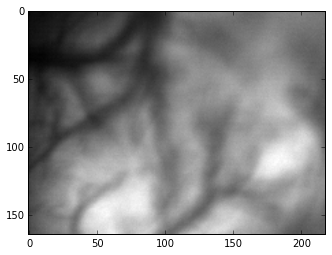

In [183]:
%matplotlib inline
tiff = TIFF.open(os.path.join(imdir, files[0]), mode='r')
sample = tiff.read_image().astype('float')
print "sample type: %s, range: %s" % (sample.dtype, str([sample.max(), sample.min()]))
print "sample shape: %s" % str(sample.shape)
tiff.close()
plt.imshow(sample, cmap='gray')

In [184]:
# FIND CYCLE STARTS:

outdir = '/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/structs'
key='stimulus'

structs = os.listdir(outdir)
structs = [f for f in structs if os.path.splitext(f)[1] == '.pkl']
dstructs = [f for f in structs if 'Target_fft' in f and str(reduce_factor) and key in f]

D = dict()
for f in dstructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		D[f] = pkl.load(fp)

print D.keys()
cw_key = D.keys()[0]

# positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
# plist = list(itertools.chain.from_iterable(positions))
# positions = [map(float, i.split(',')) for i in plist]

['Target_fft_stimulus_(1, 1)_nas.pkl']


In [185]:
print D[cw_key].keys()
# print D[cw_key]['degrees']
positions = D[cw_key]['positions']


['direction', 'phase_map', 'ft', 'mag_map', 'nframes_per_cycle', 'target_freq', 'positions', 'mean_intensity', 'freqs', 'binsize', 'dynrange', 'degrees', 'fps', 'strt_idxs', 'reduce_factor', 'target_bin']


In [186]:
positions = [re.findall("\[([^[\]]*)\]", f) for f in files]
plist = list(itertools.chain.from_iterable(positions))
pos = []
for i in plist:
    split_string = i.split(' ')
    split_num = [float(s) for s in split_string if s is not '']
    pos.append([split_num[0], split_num[1]])

degs = [cart2pol(p[0], p[1], units='deg') for p in pos]

degrees = [i[0] for i in degs]
shift_degrees = [i[0] for i in degs]
for x in range(len(shift_degrees)):
    if shift_degrees[x] < 0:
        shift_degrees[x] += 360.

if CW:
    find_cycs = list(itertools.chain.from_iterable(np.where(np.diff(shift_degrees) > 0)))
else:
    find_cycs = list(itertools.chain.from_iterable(np.where(np.diff(shift_degrees) < 0)))

In [187]:
print find_cycs

[460, 921, 1383, 1844, 2306, 2767, 3229, 3690, 4152, 4614, 5075, 5537, 5998, 6460, 6921, 7383, 7844, 8306, 8768]


In [188]:
from psychopy import visual, event, core, monitors, logging, tools

In [189]:
monitor_list = monitors.getAllMonitors()

In [190]:
monitor_list

[u'AQUOS', u'testMonitor', u'BenQtest', u'syncmaster2433BW']

In [191]:
whichMonitor = 'AQUOS'
# whichMonitor = 'syncmaster2433BW'

In [192]:
winsize = monitors.Monitor(whichMonitor).getSizePix()

In [193]:
winsize

[1360, 768]

In [194]:
screen_width_cm = monitors.Monitor(whichMonitor).getWidth()
screen_height_cm = (float(screen_width_cm)/monitors.Monitor(whichMonitor).getSizePix()[0])*monitors.Monitor(whichMonitor).getSizePix()[1]

screen_width_deg = tools.monitorunittools.cm2deg(screen_width_cm, monitors.Monitor(whichMonitor))
screen_height_deg = tools.monitorunittools.cm2deg(screen_height_cm, monitors.Monitor(whichMonitor))

print [screen_width_deg, screen_height_deg]



[213.11945001432255, 120.34980706691158]


In [48]:
# win = visual.Window(fullscr=True, rgb=-1, size=winsize, units='deg', monitor=whichMonitor)

In [49]:
# win.close()

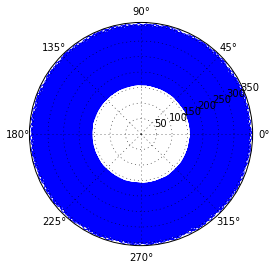

In [133]:
# Using linspace so that the endpoint of 360 is included...

fig = plt.figure()
d = np.array(D[cw_key]['degrees'])

# P = np.ones((len(d), 2))

# P[:,1] *= D[cw_key]['degrees']

# r=np.arange(0,P.shape[1],1)
# t=np.arange(0,np.shape(P)[0],1)

# R,T  = np.meshgrid(r,t)

R = np.ones(d.shape)
P = np.ones((2, len(d)))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
plt.plot(d)


# azimuths = np.radians(np.linspace(0, 360, 20))
# zeniths = np.arange(10, 70, 10)

# r, theta = np.meshgrid(zeniths, azimuths)
# values = np.random.random((azimuths.size, zeniths.size))

# #-- Plot... ------------------------------------------------
# fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
# ax.contourf(theta, r, values)

# plt.show()

In [153]:
pos = [i[0] for i in degs]
pos[0:50]

[-0.0054227828942816393,
 -0.81033782282808053,
 -1.5677979531243473,
 -2.3426645262349517,
 -3.1182786948007459,
 -3.9022278818126295,
 -5.4615122750610778,
 -5.8660563484895238,
 -6.6456427506829812,
 -7.4251510571549426,
 -8.2047374794515928,
 -9.3622896274005676,
 -9.7641669219245575,
 -10.543284695915855,
 -11.323395546343868,
 -12.478894621412898,
 -12.882311719017888,
 -13.66208781779426,
 -14.44168539270537,
 -15.221461489276496,
 -16.376447296796435,
 -16.781359579795335,
 -17.561236087730251,
 -18.341391568239288,
 -19.496734421025849,
 -19.901133448155228,
 -20.681244273507797,
 -21.461120795727137,
 -22.241934583565691,
 -23.395693026018318,
 -23.80130824922016,
 -24.580805402128181,
 -25.36110591022663,
 -27.299416069703959,
 -27.704518026450884,
 -28.483557705719882,
 -29.26239652138203,
 -30.042083354907479,
 -31.198754028903064,
 -31.601702501943542,
 -32.381344702221803,
 -33.161076157305381,
 -34.313529113225712,
 -34.720963105712578,
 -35.500928878380954,
 -36.280805

(0.0, 6.2831853071795862, -1.0, 1.0)

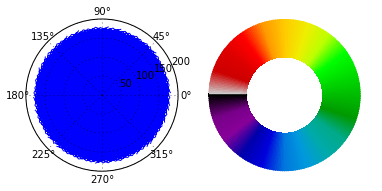

In [155]:
# POLAR / CIRCULAR COLORMAP:
import matplotlib as mpl
import matplotlib.cm as cm

fig = plt.figure()

ax = fig.add_subplot(1,2,1, projection='polar')
plt.plot(pos)

ax = fig.add_subplot(1,2,2, projection='polar')
ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

ax._direction = 2*np.pi # object moves toward bottom first (CW)

# ax._direction = -2*np.pi # objecct moves toward top first (CCW)

norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
#norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
                                norm=norm, orientation='horizontal')
# cb.ax.invert_xaxis()
# cb.outline.set_visible(False)
# ax.set_axis_off()
ax.set_rlim([-1, 1])
ax.axis('off')

In [50]:
len(positions)

9230

In [55]:
patch_size = (45, 45)

In [112]:
# # More weird stuff... why are timestamps so off?

# from datetime import datetime
# tstamps = [f.split('_')[1] for f in files]
# FORMAT = '%Y%m%d%H%M%S%f'
# #date = datetime.strptime(tstamps[0], FORMAT)
# #display(date)
# # convert string into math-able form:
# #'{hrs}:{min}:{sec}.{msec}'.format(hrs = str(d.hour), min = str(d.minute), sec = str(d.second), msec = str(d.microsecond/1000))
# fmt_tstamps = [datetime.strptime(t, FORMAT) for t in tstamps]
# times = ['{hrs}:{min}:{sec}.{msec}'.format(hrs = str(d.hour), min = str(d.minute), sec = str(d.second), msec = str(d.microsecond)) for d in fmt_tstamps]

In [113]:
# mstimes = []
# for t in times:
#     hours, minutes, seconds = (t.split(":"))[-3:]
#     hours = int(hours)
#     minutes = int(minutes)
#     seconds = float(seconds)
#     miliseconds = int(3600000 * hours + 60000 * minutes + 1000 * seconds)
#     mstimes.append(miliseconds)

In [195]:
window = [np.ceil(screen_width_deg), np.ceil(screen_height_deg)]
print window

[214.0, 121.0]


In [301]:
import pygame
import sys

# shift_P = [i+np.ceil(max(P)) for i in P]

# w=abs(np.ceil(abs(P[0])+barWidth)*2) # include offset to compensate for stupid positioning above...
# h=abs(np.ceil(stimSize[0]))
w = window[0]
h = window[1]
display(w,h)

black = (0,0,0)
white = (255,255,255)

pygame.init()
screen = pygame.display.set_mode((int(w),int(h)))

screen.fill(black)


214.0

121.0

<rect(0, 0, 214, 121)>

In [302]:
savedir = os.path.join(os.path.split(imdir)[0], 'simulation', cond)
if not os.path.exists(savedir):
    os.makedirs(savedir)
    
print savedir

/media/nas/volume1/widefield/data/CE004/20160203/awake_circle_0013_REV/simulation/stimulus


In [311]:
stim_size = 45.0 # in degrees
pos_vec = [pol2cart(p[0], p[1]) for p in degs]

px = [p[0] for p in pos_vec]
py = [p[1] for p in pos_vec]

old_min = min(px)
old_max = max(px)
old_range = (old_max - old_min)
new_min = 0
new_range = max(px)*2 - 0.
shift_px = [((((i - old_min) * float(new_range)) / old_range) + new_min) for i in px]
new_px = [i+(w/4.) for i in shift_px]

print px[0:5]
print shift_px[0:5]
old_min = min(py)
old_max = max(py)
old_range = (old_max - old_min)
new_min = 0
new_range = max(py)*2 - 0.
shift_py = [((((i - old_min) * float(new_range)) / old_range) + new_min) for i in py]
new_py = np.flipud([i+(h/4.) for i in shift_py])-5 
# need to flip UD because actual stim-pos assumes center of (0,0), but this is upper-left corner of pygame rect 
# also, shifted by 5 pixels to center stimulus

print py[0:5]
print shift_py[0:5]


# shift_posvec = [[shift_px[i], shift_py[i]] for i in range(len(shift_px))]
shift_posvec = [[new_px[i], new_py[i]] for i in range(len(new_py))]

[36.104942000000001, 36.101331209999991, 36.09142623999999, 36.074766859999997, 36.051483959999999]
[72.209884000000002, 72.206273209679964, 72.19636823880208, 72.179708857325551, 72.15642595526198]
[-0.0034171672699999998, -0.51061744999999992, -0.98782477999999985, -1.4758190400000004, -1.9640137799999999]
[36.101524932730001, 35.594324650000004, 35.117117320000006, 34.629123060000005, 34.14092832]


In [317]:
# test the positions...
pos_vec[0]
currpos = shift_posvec[370] 
print currpos

screen.fill(black)

pygame.draw.circle(screen, white, [int(currpos[0]), int(currpos[1])], int(stim_size/2.), 0)
pygame.display.update()

[101.81882411252279, 27.231776289999999]


In [318]:
# Create frames:

actual_nframes = len(positions)

fps = 60.
delay_secs = 5 # n seconds to wait to simulate hemo "delay"
delay_frames = delay_secs * fps

nframes = 0
while nframes < actual_nframes:

    currpos = shift_posvec[nframes]
    
    screen.fill(black)
    pygame.draw.circle(screen, white, [int(currpos[0]), int(currpos[1])], int(stim_size/2.), 0)
    pygame.display.update()

    pygame.image.save(screen, os.path.join(savedir, "screen_%i.bmp" % nframes))
    nframes += 1

In [322]:
pygame.quit()

In [61]:
nframes_collected = os.listdir(savedir)
print("N frames: %s" % str(len(nframes_collected)))
print("N positions: %s" % str(len(positions)))

N frames: 23964
N positions: 23964


In [62]:
sim_frames = sorted([i for i in nframes_collected if i.split('.')[1]=='bmp'], key=natural_keys)

In [68]:
from PIL import Image
sim=Image.open(os.path.join(savedir, sim_frames[-1]),'r')

SIM IMAGE SHAPE: (120, 93)


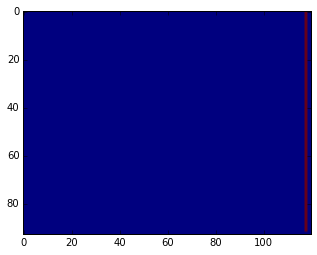

In [69]:
# is it working...?
# sim = Image.open(os.path.join("./stimuli/simulated", sim_frames[100])).convert('LA')
# sim=sim.convert('1') # make BW so don't have to deal with 3d
# lena = misc.imread(os.path.join("./stimuli/simulated", sim_frames[100]))

# sim=Image.open(os.path.join(savedir, sim_frames[100]),'r')
sim=sim.convert('L') #makes it greyscale
y=np.asarray(sim.getdata(),dtype=np.float64).reshape((sim.size[1],sim.size[0]))
y=np.asarray(y,dtype=np.uint8)

plt.imshow(y)
print "SIM IMAGE SHAPE: %s" % str(sim.size)

In [26]:
y.max()

255

In [27]:
stack = np.empty((sim.size[1], sim.size[0], len(sim_frames)))
print stack.shape

for i, f in enumerate(sim_frames):
    if i % 1000 == 0:
        print('%d images processed...' % i)
    sim=Image.open(os.path.join(savedir, sim_frames[i]),'r')
    sim=sim.convert('L') #makes it greyscale
    y=np.asarray(sim.getdata(),dtype=np.float64).reshape((sim.size[1],sim.size[0]))
    stack[:, :, i] = y

(93, 120, 23964)
0 images processed...
1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
5000 images processed...
6000 images processed...
7000 images processed...
8000 images processed...
9000 images processed...
10000 images processed...
11000 images processed...
12000 images processed...
13000 images processed...
14000 images processed...
15000 images processed...
16000 images processed...
17000 images processed...
18000 images processed...
19000 images processed...
20000 images processed...
21000 images processed...
22000 images processed...
23000 images processed...


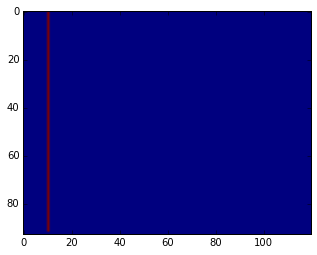

In [31]:
plt.imshow(stack[:,:,100])

In [32]:
for i in range(stack.shape[2]):
    stack[:,:,i] -= np.mean(stack[:,:,i].ravel())

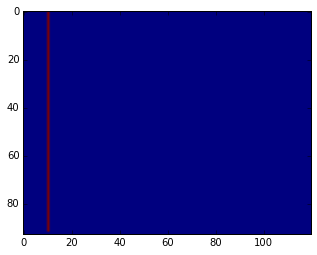

In [33]:
plt.imshow(stack[:,:,100])

In [130]:
freqs = fft.fftfreq(len(stack[0, 0, :]), 1 / sampling_rate) # When set fps to 60 vs 120 -- target_bin should be 2x higher for 120, but freq correct (looks for closest matching target_bin )
binwidth = freqs[1] - freqs[0]
#target_bin = int(target_freq / binwidth)
target_bin = np.where(freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]
print "TARGET: ", target_bin, freqs[target_bin]
print "FREQS: ", freqs

TARGET:  20 0.050075112669
FREQS:  [ 0.          0.00250376  0.00500751 ..., -0.00751127 -0.00500751
 -0.00250376]


In [131]:

# FFT:
sample = stack[:,:,0]
mag_map = np.empty(sample.shape)
phase_map = np.empty(sample.shape)

ft_real = np.empty(sample.shape)
ft_imag = np.empty(sample.shape)

ft_real_shift = np.empty(sample.shape)
ft_imag_shift = np.empty(sample.shape)

dynrange = np.empty(sample.shape)

ft = np.empty(sample.shape)
ft = ft + 0j

#dlist = []
i = 0
for x in range(sample.shape[0]):
    for y in range(sample.shape[1]):

        # THIS IS BASICALLY MOVING AVG WINDOW...
        pix = scipy.signal.detrend(stack[x, y, :], type='constant')

        #dynrange[x, y] = np.log2(pix.max() - pix.min())

        curr_ft = fft.fft(pix)  # fft.fft(pix) / len(pix)])
        #curr_ft_shift = fft.fftshift(curr_ft)

# DF = pd.DataFrame.from_records(dlist)

        #mag = np.abs(curr_ft)
        # mag_max = np.where(mag == mag.max())
        # mag_min = np.where(mag == mag.min())
        
        phase = np.angle(curr_ft)

        ft_real[x, y] = curr_ft[target_bin].real
        ft_imag[x, y] = curr_ft[target_bin].imag
        
        ft[x,y] = curr_ft[target_bin]

        #ft_real_shift[x, y] = curr_ft_shift[target_bin_shift].real
        #ft_imag_shift[x, y] = curr_ft_shift[target_bin_shift].imag

        # if i % 100 == 0:
        # print ft_real[x, y], ft_imag[x,y]

        #mag_map[x, y] = mag[target_bin]
        phase_map[x, y] = phase[target_bin]

        #dlist.append((x, y, curr_ft))

        i += 1

In [132]:
os.path.split(os.path.split(savedir)[0])[0]

'./tests/simulation'

In [34]:
outdir = os.path.join(os.path.split(os.path.split(savedir)[0])[0], "structs")
append_to_name = "simulated"
outdir


'./tests/simulation/structs'

In [134]:

D = dict()

D['ft_real'] = ft_real  # np.array(ft)
D['ft_imag'] = ft_imag
D['ft'] = ft

# D['mag_map'] = mag_map
D['phase_map'] = phase_map

D['mean_intensity'] = np.mean(stack, axis=2)
#D['stack'] = stack
#del stack
D['dynrange'] = dynrange
D['target_freq'] = target_freq
D['fps'] = sampling_rate
D['freqs'] = freqs  # fft.fftfreq(len(pix), 1 / sampling_rate)
# D['freqs_shift'] = freqs_shift #fft.fftfreq(len(pix), 1 / sampling_rate)

D['binsize'] = freqs[1] - freqs[0]
# np.where(freqs == min(freqs, key=lambda x: abs(float(x) - target_freq)))[0][0]
D['target_bin'] = target_bin
#D['target_bin_shift'] = target_bin_shift
D['nframes'] = nframes_per_cycle
D['reduce_factor'] = reduce_factor

# SAVE condition info:
sessionpath = os.path.split(imdir)[0]
# outdir = os.path.join(sessionpath, 'structs')
# if not os.path.exists(outdir):
#     os.makedirs(outdir)

reduce_factor = (1, 1)
fext = 'D_target_FFT_%s_%s_%s.pkl' % (cond, str(reduce_factor), append_to_name)
fname = os.path.join(outdir, fext)
with open(fname, 'wb') as f:
    # protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(D, f, protocol=pkl.HIGHEST_PROTOCOL)

In [49]:
# outdir = "./tests/simulation/V-Left_0/structs"
os.listdir(outdir)
outdir

'./tests/simulation/structs'

In [38]:
#####################################################
# TEST MERGE:
#####################################################

reduce_factor = (1,1)
print outdir
flist = os.listdir(outdir)

flist = [f for f in flist if os.path.splitext(f)[1] == '.pkl']
print flist
dstructs = [f for f in flist if 'D_target_FFT' in f and str(reduce_factor) in f]
# if not dstructs:
#     dstructs = [f for f in flist if 'D_' in f and str(reduce_factor) in f]

print dstructs
    
D = dict()
for f in dstructs:
    outfile = os.path.join(outdir, f)
    with open(outfile,'rb') as fp:
        D[f] = pkl.load(fp)

./tests/simulation/structs
['D_target_V-Right_0_(1, 1)_simulated_orig.pkl', 'D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl', 'D_target_V-Right_0_(1, 1)_simulated.pkl', 'D_target_V-Left_0_(1, 1)_True.pkl']
['D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl']


In [39]:
for d in D.keys():
    if "Left" in d:
        leftkey = d
    elif "Right" in d:
        rightkey = d
print D.keys()

['D_target_FFT_V-Right_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Down_0_(1, 1)_simulated.pkl', 'D_target_FFT_V-Left_0_(1, 1)_simulated.pkl', 'D_target_FFT_H-Up_0_(1, 1)_simulated.pkl']


In [40]:
# print min([ftmap[rightkey].shape, ftmap[leftkey].shape])
# leftmap = np.zeros(min([ftmap[rightkey].shape, ftmap[leftkey].shape]))
# rightmap = np.zeros(min([ftmap[rightkey].shape, ftmap[leftkey].shape]))

# leftmap = leftmap + 0j
# rightmap = rightmap + 0j


leftmap = D[leftkey]['ft']
rightmap = D[rightkey]['ft'][:,0:120]

In [41]:
rightmap.shape

(93, 120)

<matplotlib.colorbar.Colorbar instance at 0x7fe81aa3ab48>

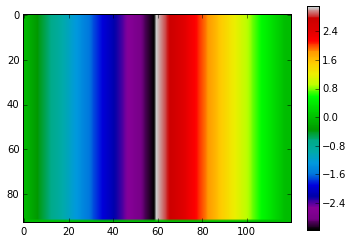

In [45]:
phase_left = np.angle(leftmap)
plt.imshow(phase_left, cmap='spectral')
plt.colorbar()

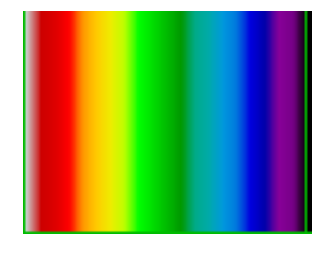

In [55]:
# SHIFT NEGATIVE VALUES by 2PI

import math
phase_left = np.angle(leftmap)
phase_right = np.angle(rightmap)

for x in range(phase_left.shape[0]):
    for y in range(phase_left.shape[1]):
        if phase_left[x,y] < 0:
            phase_left[x,y] += 2*math.pi

for x in range(phase_right.shape[0]):
    for y in range(phase_right.shape[1]):
        if phase_right[x,y] < 0:
            phase_right[x,y] += 2*math.pi

        
# plt.imshow(phase_left, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
phase_left

# plt.subplot(1,2,2)
# plt.imshow(phase_right, cmap='spectral')
# plt.colorbar()
        
az = (phase_left - phase_right) / 2.
# plt.imshow(az, cmap='spectral') #, vmin=-1*math.pi, vmax=1*math.pi)
plt.imshow(az, cmap='spectral') #, vmin=0, vmax=2*math.pi)
# plt.colorbar()
# plt.colorbar()
# x = np.where(phase_left<0)
# len(x[1])
# phase_left.max()
az.min()

plt.axis('off')

# plt.colorbar()

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/LEFT_RIGHT_legend.tif'
plt.savefig(legend_path)
# print az[-5]

[-0.01195602  3.0944027   3.04197291  2.98841946  2.93469808  2.88180209
  2.82806864  2.77426141  2.72070648  2.66733827  2.61372288  2.5600421
  2.50731928  2.45410418  2.40057897  2.3471697   2.294454    2.24048406
  2.18564951  2.13244588  2.07985851  2.0262631   1.97270509  1.92004939
  1.86670288  1.81263785  1.75940072  1.70602805  1.65173487  1.59798351
  1.54523141  1.49182359  1.43813036  1.38520015  1.33248408  1.27882825
  1.22426392  1.17071791  1.11748489  1.06390282  1.0106508   0.95801693
  0.90452628  0.85040859  0.79749212  0.74468339  0.68991967  0.63580173
  0.58314353  0.52992716  0.47618642  0.42323225  0.37080246  0.31697272
  0.26290952  0.20954962  0.15540267  0.10136844  0.04835885 -0.00407094
 -0.05751778 -0.11135659 -0.16430105 -0.21727293 -0.27137617 -0.32551267
 -0.37894434 -0.4324741  -0.48597567 -0.53885563 -0.59136951 -0.64540118
 -0.69930218 -0.75210892 -0.8063921  -0.86060768 -0.91367423 -0.96615881
 -1.01966649 -1.07334728 -1.1260701  -1.17954192 -1.

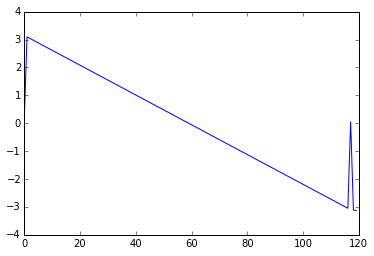

In [59]:
plt.plot(az[-5])
print az[-5]

<matplotlib.colorbar.Colorbar instance at 0x7f01d2174b48>

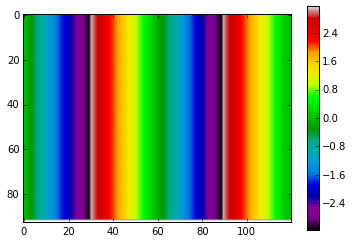

In [168]:
#########################################################################
# STIM MAPS:
#########################################################################

azimuth_phase = np.angle( (leftmap / rightmap) )
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()
# THIS IS DOUBLE-COLOR-MAPPED, i.e., [from LEFT --> RIGHT] 0 --> -pi, pi --> 0 --> -pi, pi --> 0.

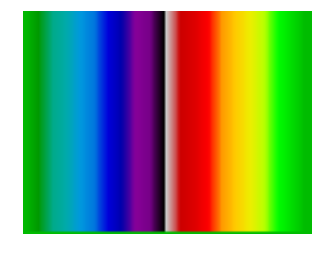

In [172]:
#####################################################
# V-LEFT_0 STIMULATION:
# ---------------------------------------------------
plt.imshow(np.angle(leftmap), cmap='spectral')
plt.axis('off')

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/V-Left_legend.tif'
plt.savefig(legend_path)
#####################################################
# THIS IS GOING:
# 0 (LEFT edge) to -pi, to pi, back to 0

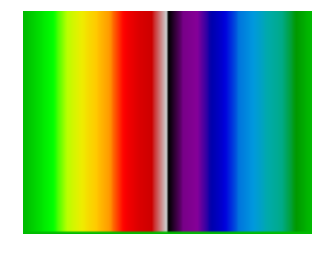

In [171]:
#####################################################
# V-RIGHT_0 STIMULATION:
# ---------------------------------------------------
plt.imshow(np.angle(rightmap), cmap='spectral')
plt.axis('off')

legend_path = '/home/juliana/Repositories/retinotopy-mapper/tests/simulation/V-Right_legend.tif'
plt.savefig(legend_path)
#####################################################
# THIS IS GOING:
# 0 (right edge) to -pi, to pi, back to 0

<matplotlib.colorbar.Colorbar instance at 0x7f01d29a8320>

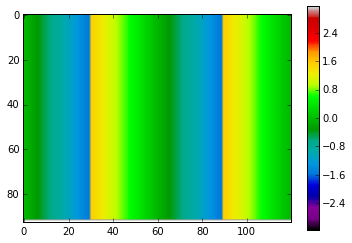

In [156]:
azimuth_phase = np.angle(leftmap / rightmap) / 2
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f01d286e488>

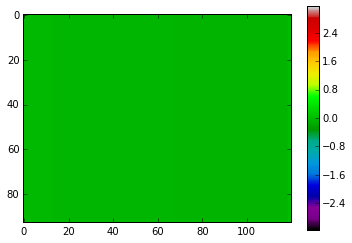

In [157]:
#########################################################################
# DELAY MAP:
#########################################################################
delay_vert = np.angle(leftmap * rightmap) / 2
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2. 
plt.imshow(delay_vert, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

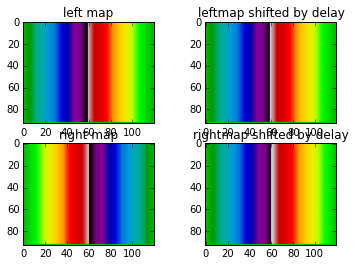

In [158]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2

fig = plt.figure()
fig.add_subplot(2,2,1)
left_phase = np.angle(leftmap)
plt.imshow(left_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('left map')

fig.add_subplot(2,2,2)
# azimuth_phase = np.angle(leftmap.conjugate()) - delay_vert
azimuth_phase = np.angle(leftmap) - delay_vert
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# plt.colorbar()
plt.title('leftmap shifted by delay')

fig.add_subplot(2,2,3)
right_phase = np.angle(rightmap)
plt.imshow(right_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('right map')

fig.add_subplot(2,2,4)
azimuth_phase = np.angle(rightmap.conjugate()) - delay_vert
# azimuth_phase = np.angle(rightmap) - delay_vert
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# plt.colorbar()
plt.title('rightmap shifted by delay')

<matplotlib.colorbar.Colorbar instance at 0x7fe81a88f200>

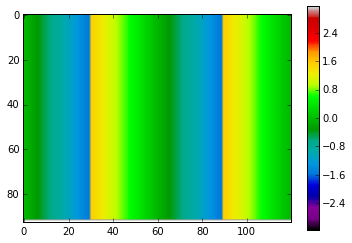

In [46]:
azimuth_phase = np.angle(leftmap / rightmap) / 2. 
# azimuth_phase = ( np.angle(rightmap) - np.angle(leftmap) ) / 2. 
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f01d2448368>

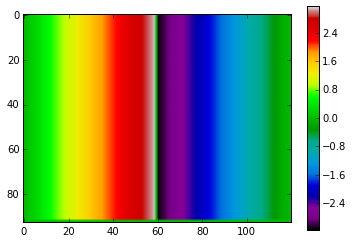

In [160]:
# azimuth_phase = np.angle(leftmap / rightmap) / 2. 
azimuth_phase = ( np.angle(rightmap) - np.angle(leftmap) ) / 2. 
# fig=plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# cbar = plt.colorbar(fig) 
# cbar.ax.invert_yaxis()
plt.imshow(azimuth_phase, cmap='spectral', vmin=1*math.pi, vmax=-1*math.pi)
plt.colorbar()

In [161]:
###########################################################################################################

In [162]:
# DONT DO THIS.

# ftmap = dict()
# # outshape = D[D.keys()[0]]['ft_real'].shape
# # print outshape
# for curr_key in D.keys():
#     outshape = D[curr_key]['ft_real'].shape # WTF, outshape changing based on stim... (but maybe not for actual imaging acquis. data)
#     print outshape
#     reals = D[curr_key]['ft_real'].ravel()
#     imags = D[curr_key]['ft_imag'].ravel()
# #     imags = imags*-1.
# #     if 'Down' in curr_key:
# #         imags = imags*-1
# #     if 'Right' in curr_key:
# #         imags = imags*-1
#     ftmap[curr_key] = [complex(x[0], x[1]) for x in zip(reals, imags)]
#     ftmap[curr_key] = np.reshape(np.array(ftmap[curr_key]), outshape)


In [822]:
# WTF, why multipling by -1.... imags are just imags!

i = 2
j = -3
c = complex(2,3)
# c = 2-3j
# print c
print c.real
print c.imag

c = 2-3j
print type(c)
cr = c.real
ci = c.imag
print cr, ci

2.0
3.0
<type 'complex'>
2.0 -3.0


In [ ]:
###########################################################################################################

In [1191]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba)

from matplotlib import cm


(0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)


(0.80000000000000004, 0.80000000000000004, 0.80000000000000004, 1.0)

In [1234]:
# map_shape = leftmap.shape
# screen_legend = np.zeros(map_shape)

screen_size = [int(i*0.25) for i in winsize]
print screen_size
screen_legend = np.zeros((screen_size[1], screen_size[0]))

VERT = 1
left = 1

if VERT: 
    if left:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    if right:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

if HORZ:
    if up:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[0]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    if right:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

plt.imshow(screen_legend, cmap='spectral')

[480, 300]


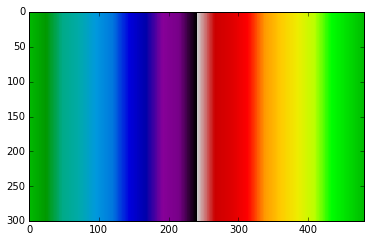

In [1235]:
###################################################
# V-LEFT:
###################################################

plt.imshow(screen_legend, cmap='spectral')

In [1233]:
screen_legend[i][240]

0.0

In [1221]:
screen_legend[i].shape

(480,)

In [1240]:
screen_size = [int(i*0.25) for i in winsize]
print screen_size
screen_legend = np.zeros((screen_size[1], screen_size[0]))

VERT = 1
left = 0

HORZ = 0
up = 1

if VERT: 
    if left:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    else:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end

if HORZ:
    if up:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, -1*math.pi, screen_size[0]/2)
        for i in range(screen_size[0]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end
    else:
        # First, set half the screen width (0 to 239 = to 0 to -pi)
        nspaces_start = np.linspace(0, 1*math.pi, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][0:screen_size[0]/2] = nspaces_start
        # Then, set right side of screen (240 to end = to pi to 0)
        nspaces_end = np.linspace(-1*math.pi, 0, screen_size[0]/2)
        for i in range(screen_size[1]):
            screen_legend[i][screen_size[0]/2:] = nspaces_end


[480, 300]


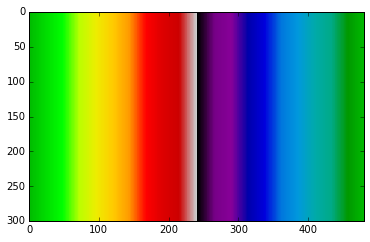

In [1241]:
###################################################
# V-RIGHT:
###################################################

plt.imshow(screen_legend, cmap='spectral')
